# Introduction

In this part of the project, I'm going to develop ML models created in the previous part.

## Loading data

In [2]:
import pandas as pd
import os

def read_data(file_path: str) -> pd.DataFrame:
    if not os.path.isfile(file_path):
        raise Exception(f'File {file_path} doesn\'t exist')
    else:
        data = pd.read_csv(file_path,
                           usecols=['sofifa_id',
                                    'short_name',
                                    'player_positions',
                                    'overall',
                                    'potential',
                                    'value_eur',
                                    'wage_eur',
                                    'age',
                                    'height_cm',
                                    'weight_kg',
                                    'club_name',
                                    'league_name',
                                    'nationality_name',
                                    'preferred_foot',
                                    'pace',
                                    'shooting',
                                    'passing',
                                    'dribbling',
                                    'defending',
                                    'physic'])
        print('File loaded succesfully')

    data.set_index(['sofifa_id', 'short_name'], inplace=True)
    data['player_positions'] = data['player_positions'].apply(lambda x: x.split(', '))
    return data

df = read_data("players_22.csv")

File loaded succesfully


In [3]:
X = df[['overall', 'potential', 'age', 'wage_eur']].values
y = df['value_eur'].values

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

y_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

y = y_pipeline.fit_transform(y.reshape(-1, 1)).ravel()

## Defining base model

In [5]:
import numpy as np
from sklearn.utils import shuffle

class GradientDescentLinearRegression:
    def __init__(self, lr=0.01, n_epochs=100, batch_size=32):
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.theta = None

    def fit(self, X, y, X_val=None, y_val=None):
        self.train_costs = []
        self.val_costs = []
        m, n = X.shape
        X_b = np.c_[np.ones((m, 1)), X]
        y = y.reshape(-1, 1)
        self.theta = np.zeros((n + 1, 1))

        if X_val is not None and y_val is not None:
            X_val_b = np.c_[np.ones((X_val.shape[0], 1)), X_val]
            y_val = y_val.reshape(-1, 1)

        for epoch in range(self.n_epochs):
            X_shuffled, y_shuffled = shuffle(X_b, y)
            for start in range(0, m, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                y_pred = X_batch @ self.theta
                error = y_pred - y_batch
                grad = (2 / y_batch.shape[0]) * (X_batch.T @ error)
                self.theta -= self.lr * grad

            train_pred = X_b @ self.theta
            train_loss = np.mean((train_pred - y)**2)
            self.train_costs.append(train_loss)

            if X_val is not None and y_val is not None:
                val_pred = X_val_b @ self.theta
                val_loss = np.mean((val_pred - y_val)**2)
                self.val_costs.append(val_loss)

        self.fitted_ = True
        return self

    def predict(self, X):
        m = X.shape[0]
        X_b = np.c_[np.ones((m, 1)), X]
        return (X_b @ self.theta).ravel()

# Cross validation

In [6]:
import numpy as np
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=3, shuffle=True, random_state=42)
kfold_results = []

regression_gd_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('regression', GradientDescentLinearRegression(lr=0.01, batch_size=64))
])

for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

    regression_gd_pipeline.fit(X_train, y_train)

    assert not np.any(np.isnan(y_train)), "y_train ma NaN!"

    y_pred = regression_gd_pipeline.predict(X_test)

    result = mean_squared_error(y_true=y_test,
                                y_pred=y_pred)
    
    kfold_results.append(result)

print(f"Wyniki: {kfold_results}")

Wyniki: [0.32740640962173234, 0.27819875792283216, 0.2965354227218391]


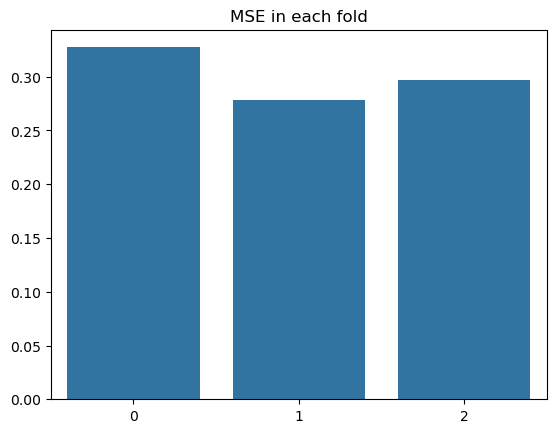

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=kfold_results)
plt.title("MSE in each fold")
plt.show()

# Over- and Underfit check using Polynomial features

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

degrees = [1, 2, 5, 10]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

train_costs = []
val_costs = []



for degree in degrees:
    preprocessing = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler())
    ])

    X_train_proc = preprocessing.fit_transform(X_train)
    X_test_proc = preprocessing.transform(X_test)

    model = GradientDescentLinearRegression(lr=0.0001, batch_size=64, n_epochs=100)
    model.fit(X_train_proc, y_train, X_val=X_test_proc, y_val=y_test)

    train_costs.append(model.train_costs)
    val_costs.append(model.val_costs)

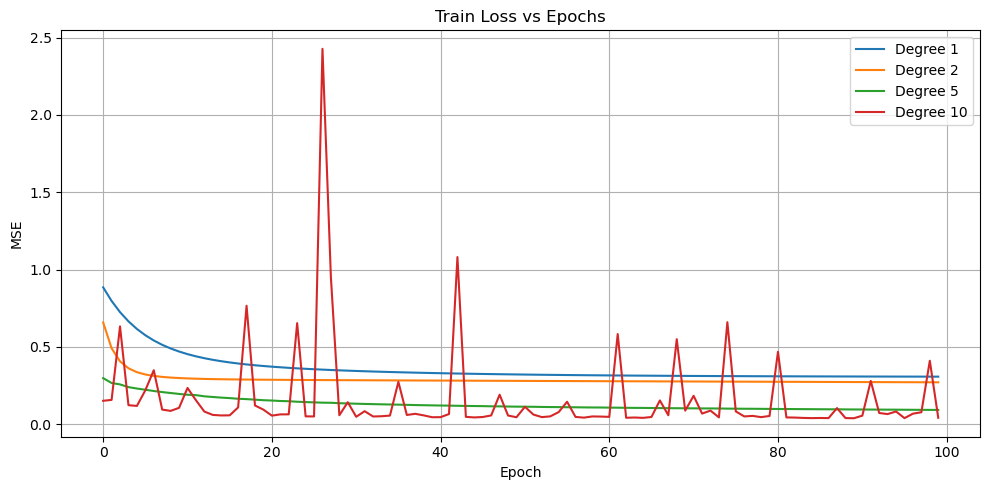

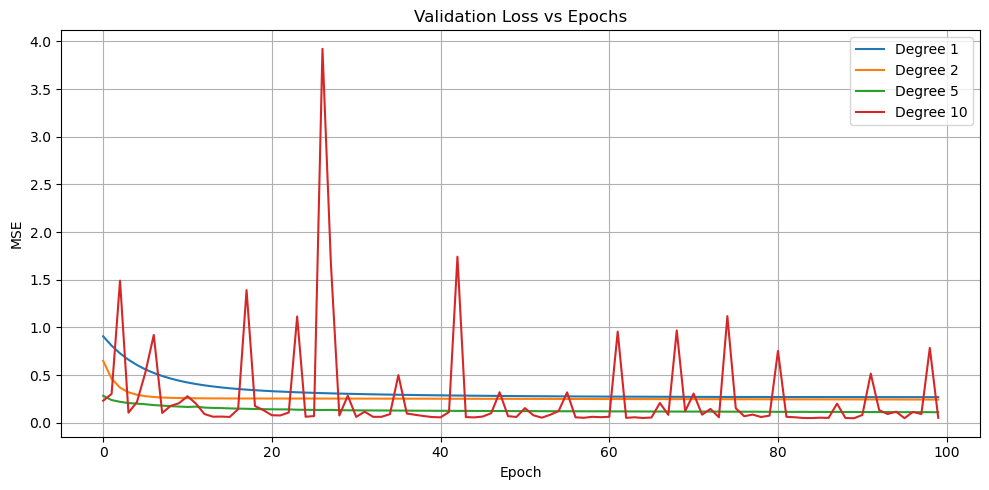

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i, costs in enumerate(train_costs):
    plt.plot(costs, label=f'Degree {degrees[i]}')
plt.title("Train Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i, costs in enumerate(val_costs):
    if costs:
        plt.plot(costs, label=f'Degree {degrees[i]}')
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Adding regularization (L2 and L1)

## L1 Lassso regularization model

In [13]:
import numpy as np
from sklearn.utils import shuffle

class GradientDescentLinearRegressionL1:
    def __init__(self, lr=0.01, n_epochs=100, batch_size=32, l1=0.0):
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.l1 = l1
        self.theta = None

    def fit(self, X, y, X_val=None, y_val=None):
        self.train_costs = []
        self.val_costs = []

        m, n = X.shape
        X_b = np.c_[np.ones((m, 1)), X]
        y = y.reshape(-1, 1)
        self.theta = np.zeros((n + 1, 1))

        if X_val is not None and y_val is not None:
            X_val_b = np.c_[np.ones((X_val.shape[0], 1)), X_val]
            y_val = y_val.reshape(-1, 1)

        for epoch in range(self.n_epochs):
            X_shuffled, y_shuffled = shuffle(X_b, y)

            for start in range(0, m, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_pred = X_batch @ self.theta
                error = y_pred - y_batch

                # L1: używamy sign() dla subgradientu, nie regularizujemy biasu
                reg_term = self.l1 * np.r_[[[0]], np.sign(self.theta[1:])]

                grad = (2 / y_batch.shape[0]) * (X_batch.T @ error) + reg_term
                self.theta -= self.lr * grad

            # koszt treningowy z L1
            train_pred = X_b @ self.theta
            mse_train = np.mean((train_pred - y) ** 2)
            reg_cost = self.l1 * np.sum(np.abs(self.theta[1:]))
            self.train_costs.append(mse_train + reg_cost)

            # koszt walidacyjny z L1
            if X_val is not None and y_val is not None:
                val_pred = X_val_b @ self.theta
                mse_val = np.mean((val_pred - y_val) ** 2)
                reg_val_cost = self.l1 * np.sum(np.abs(self.theta[1:]))
                self.val_costs.append(mse_val + reg_val_cost)

        self.fitted_ = True
        return self

    def predict(self, X):
        if not hasattr(self, 'fitted_'):
            raise ValueError("Model nie został jeszcze dopasowany.")
        m = X.shape[0]
        X_b = np.c_[np.ones((m, 1)), X]
        return (X_b @ self.theta).ravel()


## L2 Ridge regularization

In [14]:

class GradientDescentLinearRegressionL2:
    def __init__(self, lr=0.01, n_epochs=100, batch_size=32, l2=0.0):
        """
        lr - learning rate
        n_epochs - liczba epok
        batch_size - rozmiar minibatcha
        l2 - współczynnik regularyzacji L2 (0.0 = brak regularyzacji)
        """
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.l2 = l2
        self.theta = None

    def fit(self, X, y, X_val=None, y_val=None):
        self.train_costs = []
        self.val_costs = []

        m, n = X.shape
        X_b = np.c_[np.ones((m, 1)), X]
        y = y.reshape(-1, 1)
        self.theta = np.zeros((n + 1, 1))

        if X_val is not None and y_val is not None:
            X_val_b = np.c_[np.ones((X_val.shape[0], 1)), X_val]
            y_val = y_val.reshape(-1, 1)

        for epoch in range(self.n_epochs):
            X_shuffled, y_shuffled = shuffle(X_b, y)

            for start in range(0, m, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_pred = X_batch @ self.theta
                error = y_pred - y_batch

                # L2 regularyzacja (bez biasu)
                reg_term = self.l2 * np.r_[[[0]], self.theta[1:]]

                grad = (2 / y_batch.shape[0]) * (X_batch.T @ error) + reg_term
                self.theta -= self.lr * grad

            # koszt treningowy z L2
            train_pred = X_b @ self.theta
            mse_train = np.mean((train_pred - y) ** 2)
            reg_cost = self.l2 * np.sum(self.theta[1:] ** 2)
            self.train_costs.append(mse_train + reg_cost)

            # koszt walidacyjny z L2
            if X_val is not None and y_val is not None:
                val_pred = X_val_b @ self.theta
                mse_val = np.mean((val_pred - y_val) ** 2)
                reg_val_cost = self.l2 * np.sum(self.theta[1:] ** 2)
                self.val_costs.append(mse_val + reg_val_cost)

        self.fitted_ = True
        return self

    def predict(self, X):
        if not hasattr(self, 'fitted_'):
            raise ValueError("Model nie został jeszcze dopasowany.")
        m = X.shape[0]
        X_b = np.c_[np.ones((m, 1)), X]
        return (X_b @ self.theta).ravel()

## Results comparison

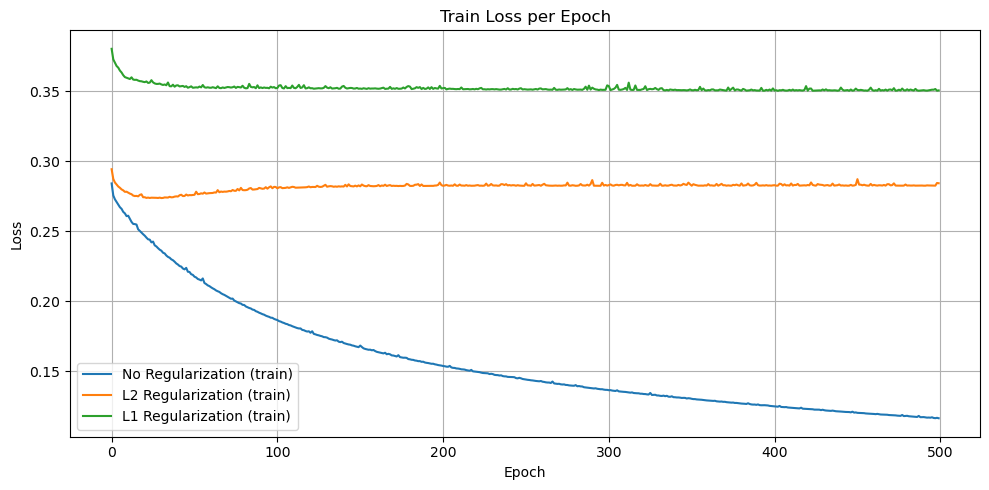

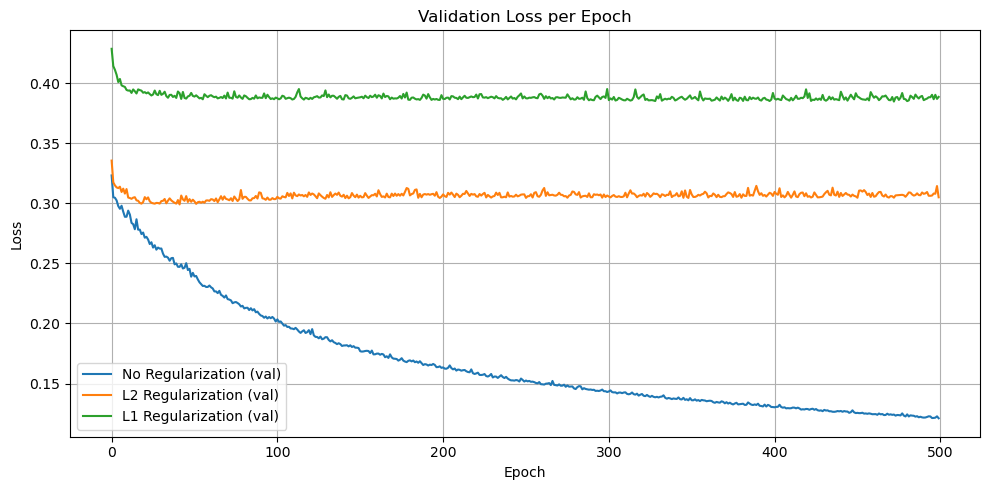

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

X_train_proc = preprocessing.fit_transform(X_train)
X_test_proc = preprocessing.transform(X_test)

params = dict(lr=0.001, n_epochs=500, batch_size=64)

models = {
    "No Regularization": GradientDescentLinearRegression(**params),
    "L2 Regularization": GradientDescentLinearRegressionL2(**params, l2=0.1),
    "L1 Regularization": GradientDescentLinearRegressionL1(**params, l1=0.1)
}

results = {}
for name, model in models.items():
    model.fit(X_train_proc, y_train, X_val=X_test_proc, y_val=y_test)
    results[name] = {
        "train": model.train_costs,
        "val": model.val_costs
    }

plt.figure(figsize=(10, 5))
for name in results:
    plt.plot(results[name]["train"], label=f"{name} (train)")
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for name in results:
    plt.plot(results[name]["val"], label=f"{name} (val)")
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
